In [23]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [12]:
dataroot = "D:/img_align_celeba"
workers = 1
batch_size = 128
# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 64
# Number of channels 
nc = 3
# Size of z latent vector/size of generator input
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
num_epochs = 5
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs
ngpu = 1

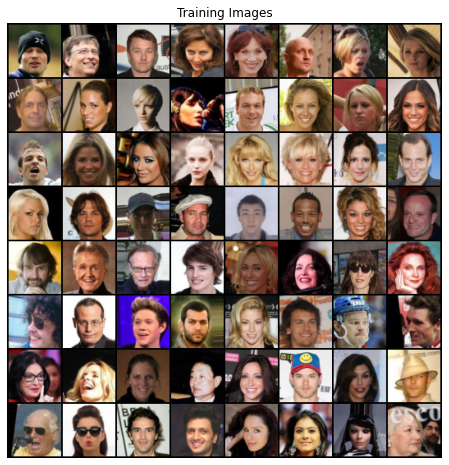

In [13]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
# a little demo here for the (1,2,0)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [14]:
#init weight
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        #Fills the input Tensor with the value \text{val}val.
        nn.init.constant_(m.bias.data, 0)

In [15]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            #-1--1
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [16]:
# init the generator
netG = Generator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)
# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [17]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [18]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [19]:
# Initialize BCELoss function
criterion = nn.BCELoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [20]:
# Training 
img_list = []
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        # Train with all-real batch
        #init the optimaizer or it will accumulate the gradients
        netD.zero_grad()
        # Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        lossD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        lossD_real.backward()
        #record mean
        D_x = output.mean().item()
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        lossD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        lossD_fake.backward()
        #record mean
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        lossD = lossD_real + lossD_fake
        # Update D
        optimizerD.step()
        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     lossD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(lossD.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.9296	Loss_G: 5.8959	D(x): 0.6343	D(G(z)): 0.6890 / 0.0051
[0/5][50/1583]	Loss_D: 0.3031	Loss_G: 34.7794	D(x): 0.8580	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.4014	Loss_G: 14.8514	D(x): 0.9697	D(G(z)): 0.2590 / 0.0000
[0/5][150/1583]	Loss_D: 0.1423	Loss_G: 2.7753	D(x): 0.9666	D(G(z)): 0.0818 / 0.1092
[0/5][200/1583]	Loss_D: 0.2585	Loss_G: 4.9921	D(x): 0.9220	D(G(z)): 0.1421 / 0.0122
[0/5][250/1583]	Loss_D: 0.2839	Loss_G: 6.5652	D(x): 0.8971	D(G(z)): 0.0960 / 0.0032
[0/5][300/1583]	Loss_D: 3.3482	Loss_G: 4.4062	D(x): 0.1417	D(G(z)): 0.0009 / 0.0332
[0/5][350/1583]	Loss_D: 0.5132	Loss_G: 3.2810	D(x): 0.8093	D(G(z)): 0.2101 / 0.0578
[0/5][400/1583]	Loss_D: 0.3183	Loss_G: 4.5882	D(x): 0.8239	D(G(z)): 0.0671 / 0.0249
[0/5][450/1583]	Loss_D: 0.9056	Loss_G: 1.6162	D(x): 0.5189	D(G(z)): 0.0240 / 0.2608
[0/5][500/1583]	Loss_D: 0.5074	Loss_G: 3.5445	D(x): 0.7519	D(G(z)): 0.1174 / 0.0415
[0/5][550/1583]	Loss_D: 0.9654	Loss_G: 5.9656	D(x):

[3/5][50/1583]	Loss_D: 0.7822	Loss_G: 1.7230	D(x): 0.6163	D(G(z)): 0.1818 / 0.2235
[3/5][100/1583]	Loss_D: 0.9382	Loss_G: 5.3529	D(x): 0.9363	D(G(z)): 0.5426 / 0.0068
[3/5][150/1583]	Loss_D: 0.6185	Loss_G: 2.9402	D(x): 0.8739	D(G(z)): 0.3529 / 0.0712
[3/5][200/1583]	Loss_D: 0.6461	Loss_G: 2.0873	D(x): 0.7304	D(G(z)): 0.2455 / 0.1492
[3/5][250/1583]	Loss_D: 0.8003	Loss_G: 4.4204	D(x): 0.9470	D(G(z)): 0.4759 / 0.0183
[3/5][300/1583]	Loss_D: 0.6287	Loss_G: 1.9679	D(x): 0.6755	D(G(z)): 0.1615 / 0.1860
[3/5][350/1583]	Loss_D: 0.6745	Loss_G: 1.5348	D(x): 0.6676	D(G(z)): 0.1867 / 0.2496
[3/5][400/1583]	Loss_D: 0.4697	Loss_G: 2.5082	D(x): 0.7410	D(G(z)): 0.1224 / 0.1108
[3/5][450/1583]	Loss_D: 1.5896	Loss_G: 0.3453	D(x): 0.2750	D(G(z)): 0.0645 / 0.7435
[3/5][500/1583]	Loss_D: 0.8388	Loss_G: 1.2736	D(x): 0.5306	D(G(z)): 0.0900 / 0.3255
[3/5][550/1583]	Loss_D: 2.4144	Loss_G: 4.6199	D(x): 0.9543	D(G(z)): 0.8627 / 0.0163
[3/5][600/1583]	Loss_D: 0.7537	Loss_G: 1.3617	D(x): 0.5858	D(G(z)): 0.1326 / 

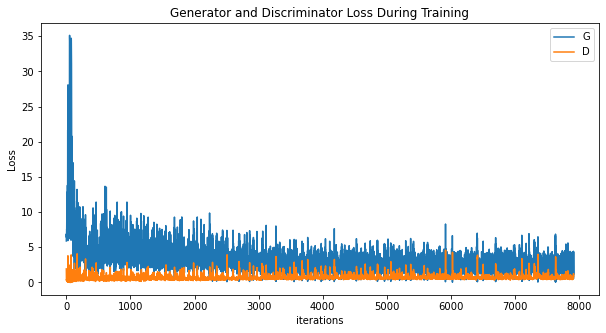

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

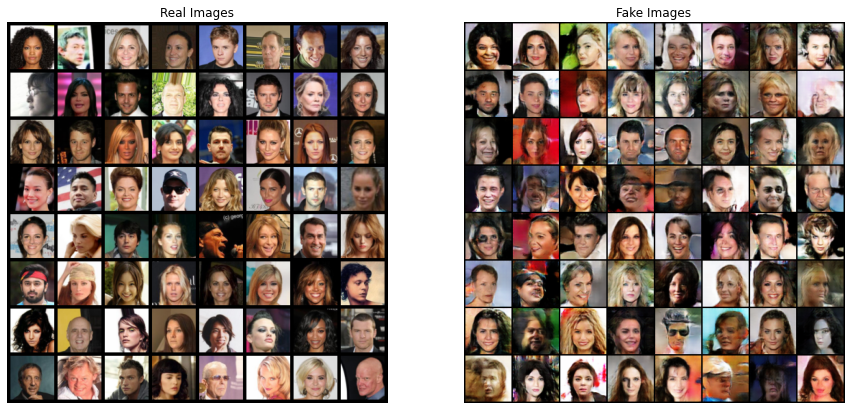

In [22]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()